The objective of this task is to predict whether it will rain or not based on Month, cloud cover, humidity, pressure, radiation, sunshine, and temperature (avg, min and max)

The dataset is from here: https://www.kaggle.com/datasets/thedevastator/weather-prediction?select=metadata.txt

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import csv

np.random.seed(0)

In [92]:
""" IMPORTING DATA """

def import_data(file_name):
    # temporarily store data in python lists
    data = []
    labels = []
    classes = 2

    with open(file_name, 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        # skip first row because it has labels
        next(csvreader)
        data_indices = np.arange(1, 11)
        data_indices = np.delete(data_indices, 5)
        class_index = 6

        for row in csvreader:
            data.append([row[i] for i in data_indices])
            labels.append(float(row[class_index]))

    data_array = np.array(data)
    data_array = data_array.astype(np.float32)
    label_array = np.zeros((len(labels), classes))

    # add bias
    bias = np.ones((len(data_array), 1))
    data_array = np.hstack((bias, data_array))
    
    # set one hot encoding
    for i, label in enumerate(labels):
        if label > 0.01:
            label = 1
        else:
            label = 0
        label_array[i][label] = 1

    class_a_count = np.sum(label_array[:, 0])
    class_b_count = np.sum(label_array[:, 1])
    # baseline accuracy is the percentage of majority class, which is accuracy score we compare to indicate the model actually learned something useful
    print(f'label statistics: class A {class_a_count}, class B {class_b_count}, baseline accuracy: {np.max(np.array([class_a_count, class_b_count]))/(len(data_array))}')
    return data_array, label_array

def split_data(X, Y, test_ratio):
    num_test = int(len(X) * test_ratio)
    test_indices = np.random.choice(len(X), num_test, replace=False)
    Xtest = X[test_indices, :]
    Ytest = Y[test_indices, :]

    X = np.delete(X, test_indices, axis=0)
    Y = np.delete(Y, test_indices, axis=0)
    return X, Y, Xtest, Ytest

In [93]:
class NeuralNetwork():

    def __init__(self, layer_sizes):
        self.weights = []

        # initializing weights to small random values
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i - 1]) * 0.1)
    
    def tanh(self, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.power(np.tanh(x), 2)

    # returns the final classification result
    def predict(self, X):
        A_0 = X.T
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        A_2 = A_2.T
        return A_2
    
    # returns full history of forward so we can perform backpropagation
    def forward(self, X):
        A_0 = X
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        return (A_0, A_1, A_2)
    
    def backward(self, X, Y):
        A_0 = X
        A_0 = A_0.reshape((len(A_0), 1))

        # forward propagation
        A_0, A_1, A_2 = self.forward(A_0)
        #print(f'shape: a0: {A_0.shape} a1: {A_1.shape} a2: {A_2.shape} y: {Y.shape}')

        # backward: error of output layer
        Y = Y.reshape((len(Y), 1))
        dA_2 = A_2 - Y

        # backward: compute weight gradient of layers
        dW_1 = dA_2 @ A_1.T
        dA_1 = self.weights[1].T @ dA_2 * self.d_tanh(A_1)
        dW_0 = dA_1 @ A_0.T

        # final gradient
        weight_gradients = [dW_0, dW_1]
        return weight_gradients

    
    def train(self, X, Y, total_epoch, learning_rate=0.03, learning_rate_decay=0.8, batch_size=1):
        print("beginning training")
        for epoch in range(total_epoch):

            # variable learning rate adjustment
            # TODO: better decay algorithm, such as checking error slope
            if epoch % (total_epoch // 10) == 0:
                learning_rate *= learning_rate_decay
                print(f"epoch {epoch} with learning rate {np.around(learning_rate, 4)}")

            temp_weights = None

            for i in range(0, len(X)):

                weight_gradients = self.backward(X[i], Y[i])

                # stohastic descent
                if batch_size < 2:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * weight_gradients[j]
                    continue

                # add weights to temp variable
                if temp_weights is None:
                    temp_weights = weight_gradients
                else:
                    for j in range(len(self.weights)):
                        temp_weights[j] += learning_rate * weight_gradients[j]    

                # if we finished batch
                if (i + 1) % batch_size == 0 or i == (len(X) - 1):
                    for j in range(len(self.weights)):
                        self.weights[j] -= (1/batch_size) * temp_weights[j]

            if epoch % (total_epoch // 10) == 0:
                accuracy = self.test(X, Y)
                print(f'training accuracy: {np.around(accuracy, 5)}')
            

    def test(self, X, Y):
        target = np.argmax(Y, axis=1)
        predict = np.argmax(self.predict(X), axis=1)
        num_incorrect = np.sum(target != predict)
        accuracy = 1 - (num_incorrect/len(X))
        self.confusion(X, Y)
        return accuracy
    
    def confusion(self, X, Y):
        confusion_matrix = np.zeros((len(Y[0]), len(Y[0])))
        target = np.argmax(Y, axis=1)
        predict = np.argmax(self.predict(X), axis=1)
        for i in range(len(X)):
            confusion_matrix[target[i], predict[i]] += 1
        print(f'confusion matrix: \n{confusion_matrix}')

In [94]:
"""TESTING"""

file = 'weather_prediction_dataset.csv'
X, Y = import_data(file)

def custom_nn():
    Xtrain, Ytrain, Xtest, Ytest = split_data(X, Y, 0.1)
    print(f'Shapes: X: {Xtrain.shape}, Y: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')

    network1 = NeuralNetwork([len(Xtrain[0]), 10, len(Ytrain[0])])

    # hyperparameters
    total_epoch = 100
    learning_rate = 0.002
    decay = 0.7
    batch_size = 1
    
    network1.train(Xtrain, Ytrain, total_epoch, learning_rate, decay, batch_size)

    accuracy = network1.test(Xtest, Ytest)
    print(f"TESTING ACCURACY: {accuracy}")

custom_nn()

label statistics: class A 2079.0, class B 1575.0, baseline accuracy: 0.5689655172413793
Shapes: X: (3289, 10), Y: (3289, 2), Xtest: (365, 10), Ytest: (365, 2)
beginning training
epoch 0 with learning rate 0.0014
confusion matrix: 
[[1247.  627.]
 [ 275. 1140.]]
training accuracy: 0.72575
epoch 10 with learning rate 0.001
confusion matrix: 
[[1295.  579.]
 [ 284. 1131.]]
training accuracy: 0.73761
epoch 20 with learning rate 0.0007
confusion matrix: 
[[1352.  522.]
 [ 318. 1097.]]
training accuracy: 0.7446
epoch 30 with learning rate 0.0005
confusion matrix: 
[[1371.  503.]
 [ 331. 1084.]]
training accuracy: 0.74643
epoch 40 with learning rate 0.0003
confusion matrix: 
[[1392.  482.]
 [ 340. 1075.]]
training accuracy: 0.75008
epoch 50 with learning rate 0.0002
confusion matrix: 
[[1400.  474.]
 [ 353. 1062.]]
training accuracy: 0.74856
epoch 60 with learning rate 0.0002
confusion matrix: 
[[1409.  465.]
 [ 356. 1059.]]
training accuracy: 0.75038
epoch 70 with learning rate 0.0001
confus

According to the confusion matrix, it was able to correctly predict each class correctly the majority of the time. Given that weather data can be highly noisy with many hidden variables not included within the dataset, an accuracy of 0.74 demonstrates that my implementation was able to learn a pattern on whether it rains or not.


I tested the above with various batch sizes, but it lead to instability. When it worked, it was able to produce a similar accuracy.

---------------------------


Below I will be implementing the same classification task but with PyTorch. I will be using a fully connected neural network with 2 hidden layers. This is done by creating an object that inherents the nn.Module object and defining a forward function. My implementation allows the neural network to be initialized with an array specifing the dimensions of each layer, with index 0 being the input and last index the output.


The following resources were used to help me write this code:

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html (functions to call for initializing network, backpropagation, updating the weights and for inferencing)

https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d (creating dataset and dataloader objects to load my dataset)

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html (using the cross entropy loss for classification)


Additionally, the train_test_split function from sklearn is used to split the data between testing and training randomly.

In [95]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cpu


In [96]:
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [97]:
class TorchNetwork(nn.Module):

    def __init__(self, dimensions):
        super().__init__()

        self.dimensions = dimensions
        self.layer_list = nn.ModuleList()
        for layer_num in range(len(dimensions) - 1):
            self.layer_list.append(nn.Linear(dimensions[layer_num], dimensions[layer_num + 1]))

    def forward(self, x):
        x = x.view(-1, self.dimensions[0])
        for i in range(len(self.layer_list)):
            x = F.relu(self.layer_list[i](x))
        return x

In [98]:
def test(net, loader, device):
    net.eval()
    correct = 0
    confusion = None

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = net(data)

            output_np = output.cpu().detach().numpy()
            answer = target.cpu().detach().numpy()
            correct += get_num_correct(output_np, answer)

            if confusion is None:
                confusion = get_confusion_matrix(output_np, answer)
            else:
                confusion += get_confusion_matrix(output_np, answer)
    
    accuracy = (correct / len(loader.dataset))
    print(f'confusion matrix: \n{confusion}')
    return accuracy


def get_num_correct(results, Y):
    target = np.argmax(Y, axis=1)
    predict = np.argmax(results, axis=1)
    num_incorrect = np.sum(target != predict)
    return len(results) - num_incorrect


def get_confusion_matrix(results, Y):
    confusion_matrix = np.zeros((len(Y[0]), len(Y[0])))
    target = np.argmax(Y, axis=1)
    predict = np.argmax(results, axis=1)
    for i in range(len(results)):
        confusion_matrix[target[i], predict[i]] += 1
    return confusion_matrix


def train(net, loader, optimizer, device):
    criterion = nn.CrossEntropyLoss()
    net.train()

    for data, target in loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)

        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

Data exporation: below, I will be graphing histograms of each feature to check for outliers and unusual data.

I will also graph some features against each other to visualize general trends.

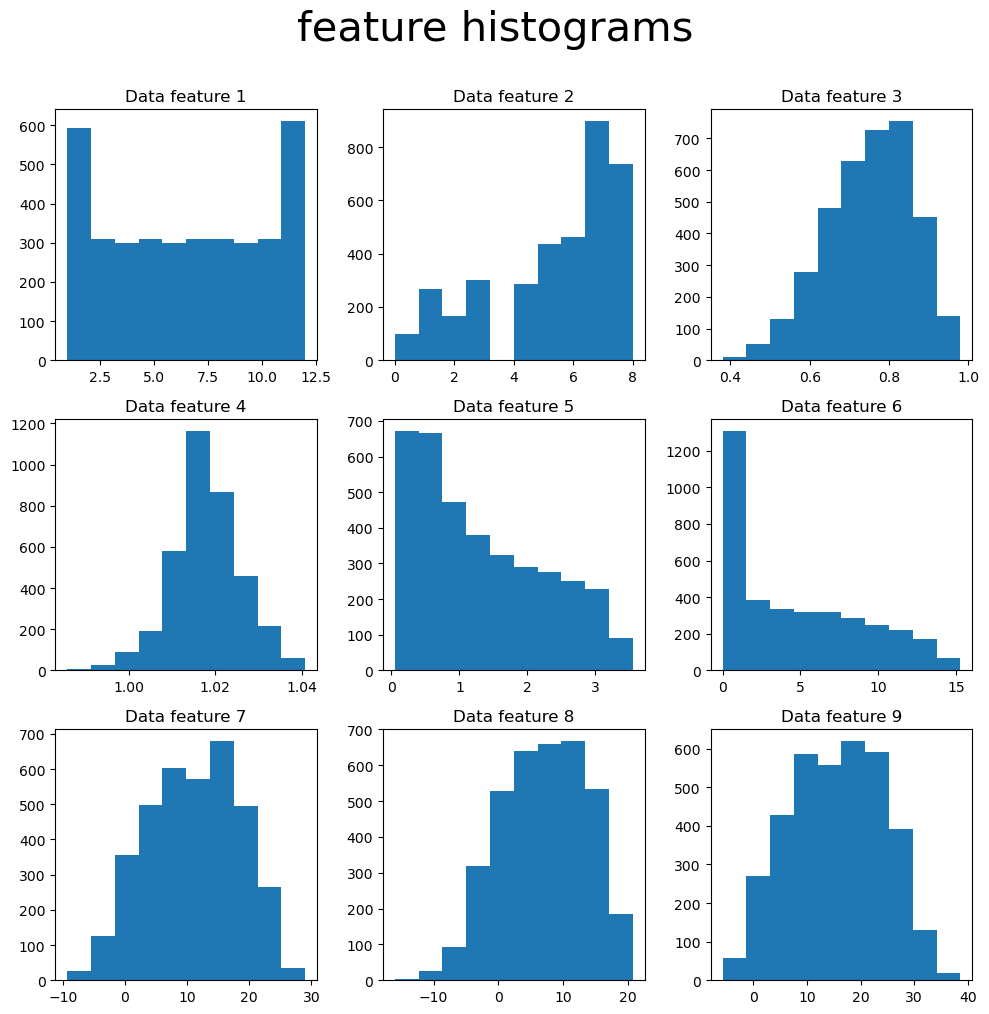

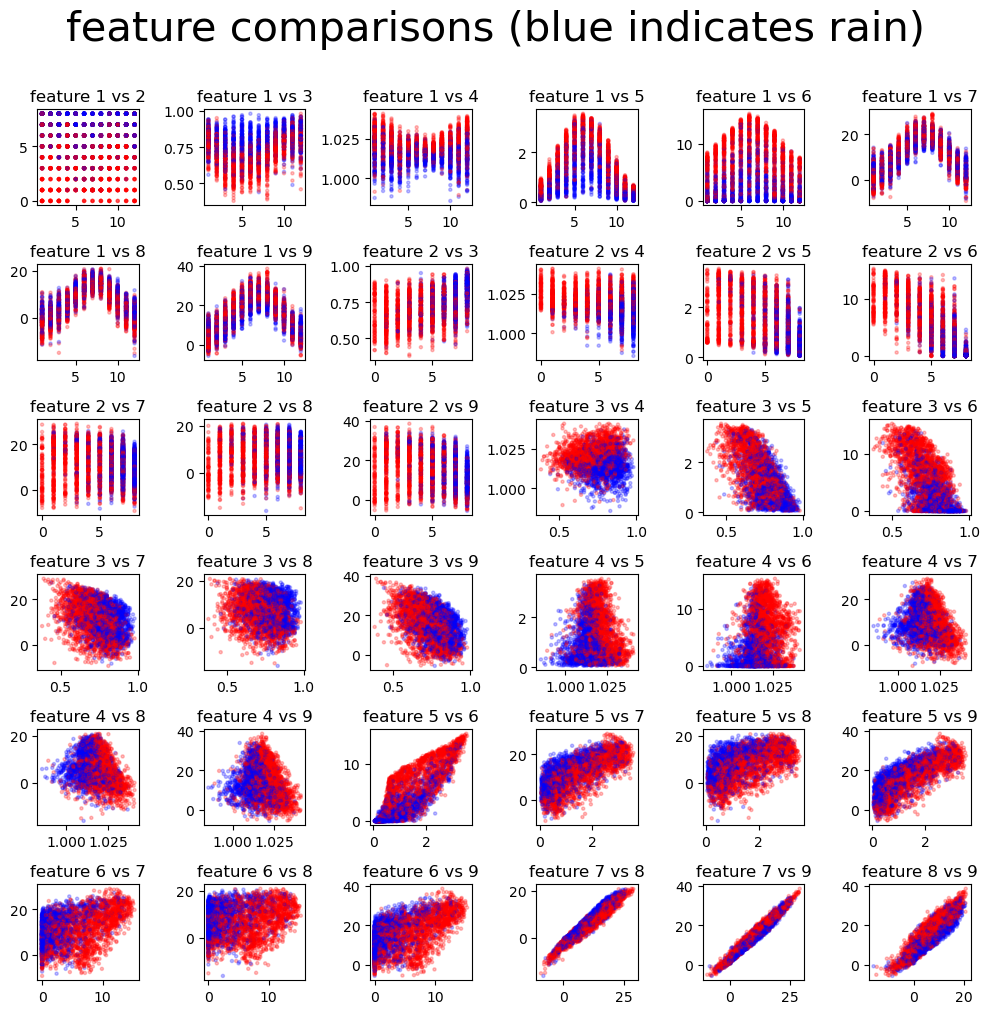

In [99]:
def plot_points(ax, X, Y):
    colors = ['blue' if value[0] == 0 else 'red' for value in Y]
    ax.scatter(X[:, 0], X[:, 1], c = colors, s=5, alpha=0.25)


def data_explore(X, Y):
    features = len(X[0])

    #NOTE: feature 0 will be ignored for visualization since it's the bias
    # histograms
    plt.figure(figsize=(10, 10))
    plots_width = int(np.ceil(np.sqrt(features - 1)))

    counter = 1
    for i in range(1, features):
        ax = plt.subplot(plots_width, plots_width, counter)
        ax.hist(X[:, i], bins=10)
        ax.set_title(f"Data feature {i}")
        counter += 1
    plt.suptitle("feature histograms", fontsize=30, y=1.01)
    plt.tight_layout()
    plt.show()

    # visualizing comparisons
    plt.figure(figsize=(10, 10))

    counter = 1
    plots_width = int(np.ceil(np.sqrt(0.5 * (features - 1) * (features - 2))))

    for i in range(1, features):
        for j in range(i + 1, features):
            ax = plt.subplot(plots_width, plots_width, counter)
            ax.set_title(f'feature {i} vs {j}')

            array = X[:, [i, j]]
            plot_points(ax, array, Y)
            counter += 1
    plt.suptitle("feature comparisons (blue indicates rain)", fontsize=30, y=1.01)
    plt.tight_layout()
    plt.show()

data_explore(X, Y)

In [100]:
def torch_nn(Xtrain, Xtest, Ytrain, Ytest, learning_rate=0.01):
    print(f'Shapes: Xtrain: {Xtrain.shape}, Ytrain: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')
    
    # hyperparameters
    dimensions = [len(Xtrain[0]), 10, 10, len(Ytrain[0])]
    train_batch_size = 10
    test_batch_size = 10
    total_epoch = 50

    # PREPARING DATA

    # Convert to torch tensors
    Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
    Ytrain = torch.tensor(Ytrain, dtype=torch.float32)
    Xtest = torch.tensor(Xtest, dtype=torch.float32)
    Ytest = torch.tensor(Ytest, dtype=torch.float32)

    # Create Dataset objects, then create torch dataloader
    train_dataset = SimpleDataset(Xtrain, Ytrain)
    test_dataset = SimpleDataset(Xtest, Ytest)

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    # CREATING NEURAL NETWORK OBJECT
    network = TorchNetwork(dimensions)
    network = network.to(device)
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    # TRAINING
    for epoch in range(total_epoch):
        train(network, train_loader, optimizer, device)
        if epoch % (total_epoch // 10) == 0:
            accuracy = test(network, train_loader, device)
            print(f'\ttraining epoch {epoch}, accuracy: {accuracy}')

    # TESTING
    print("Testing")
    accuracy = test(network, test_loader, device)
    print(f'TEST ACCURACY: {accuracy}')
    
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=0)
torch_nn(Xtrain, Xtest, Ytrain, Ytest, 0.003)

Shapes: Xtrain: (3288, 10), Ytrain: (3288, 2), Xtest: (366, 10), Ytest: (366, 2)
confusion matrix: 
[[1474.  399.]
 [ 474.  941.]]
	training epoch 0, accuracy: 0.7344890510948905
confusion matrix: 
[[1483.  390.]
 [ 461.  954.]]
	training epoch 5, accuracy: 0.7411800486618005
confusion matrix: 
[[1407.  466.]
 [ 382. 1033.]]
	training epoch 10, accuracy: 0.7420924574209246
confusion matrix: 
[[1470.  403.]
 [ 436.  979.]]
	training epoch 15, accuracy: 0.7448296836982968
confusion matrix: 
[[1423.  450.]
 [ 396. 1019.]]
	training epoch 20, accuracy: 0.7427007299270073
confusion matrix: 
[[1562.  311.]
 [ 535.  880.]]
	training epoch 25, accuracy: 0.7427007299270073
confusion matrix: 
[[1446.  427.]
 [ 399. 1016.]]
	training epoch 30, accuracy: 0.7487834549878345
confusion matrix: 
[[1393.  480.]
 [ 362. 1053.]]
	training epoch 35, accuracy: 0.7439172749391727
confusion matrix: 
[[1610.  263.]
 [ 587.  828.]]
	training epoch 40, accuracy: 0.7414841849148418
confusion matrix: 
[[1424.  44

The PyTorch performed similarily to my implementation, except it uses two hidden layers instead of just one. Increasing the number of parameters or epochs lead to overfitting.

I normalized all my features (using only training data!) and re-trained.

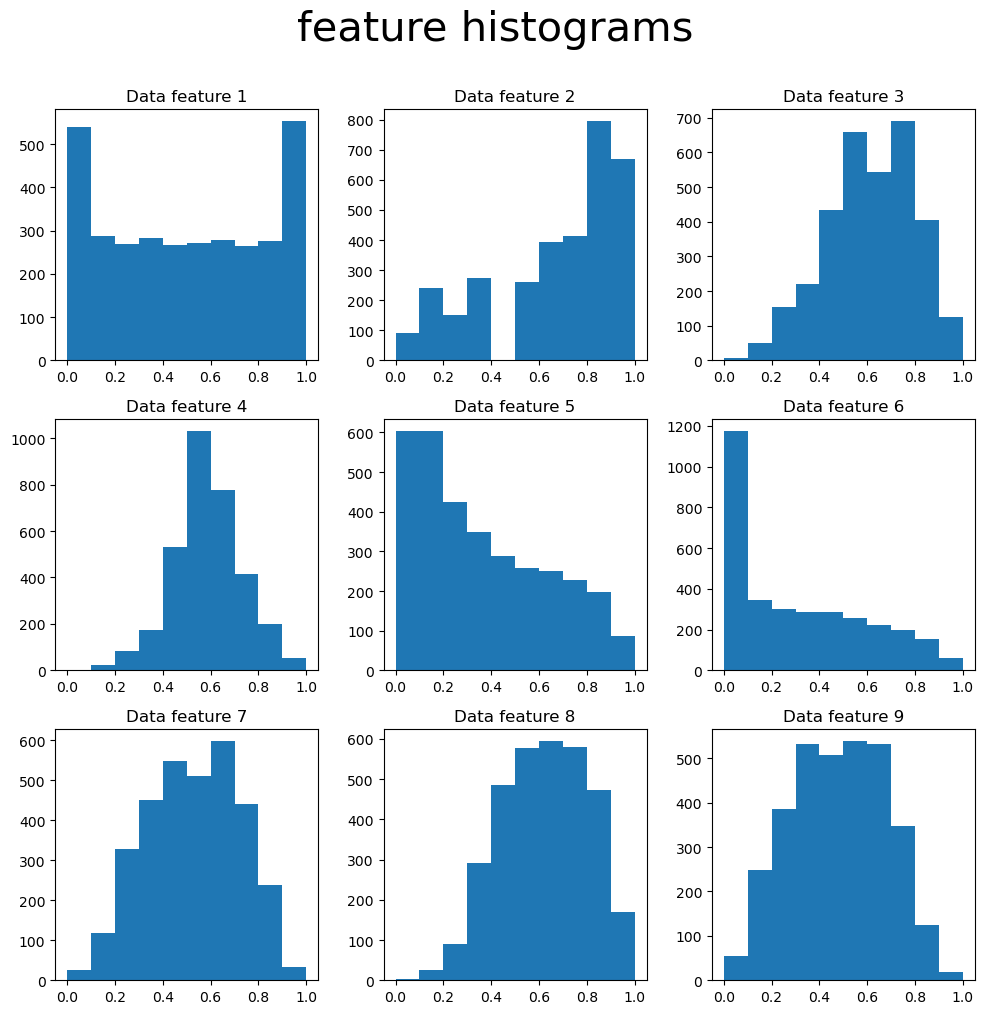

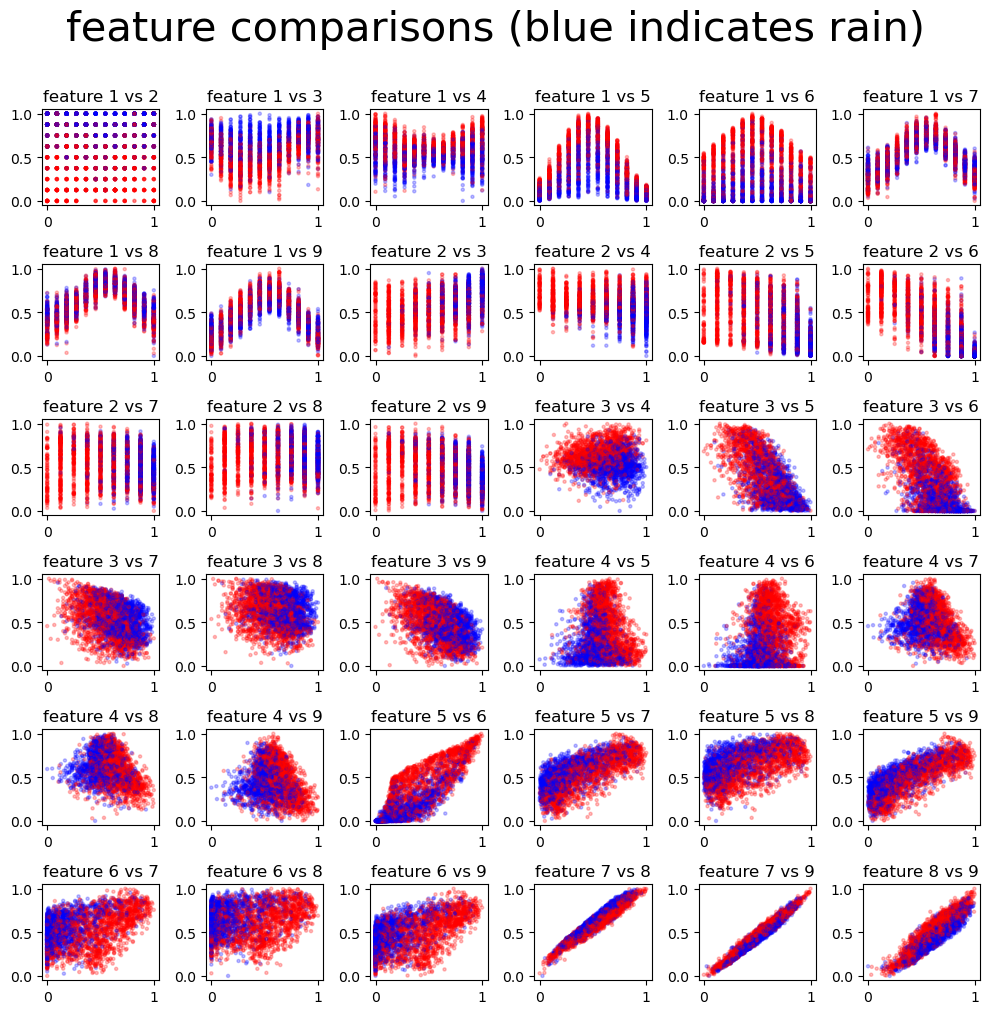

Shapes: Xtrain: (3288, 10), Ytrain: (3288, 2), Xtest: (366, 10), Ytest: (366, 2)
confusion matrix: 
[[1873.    0.]
 [1415.    0.]]
	training epoch 0, accuracy: 0.569647201946472
confusion matrix: 
[[1851.   22.]
 [1246.  169.]]
	training epoch 5, accuracy: 0.6143552311435523
confusion matrix: 
[[1391.  482.]
 [ 312. 1103.]]
	training epoch 10, accuracy: 0.7585158150851582
confusion matrix: 
[[1457.  416.]
 [ 341. 1074.]]
	training epoch 15, accuracy: 0.7697688564476886
confusion matrix: 
[[1445.  428.]
 [ 320. 1095.]]
	training epoch 20, accuracy: 0.7725060827250608
confusion matrix: 
[[1391.  482.]
 [ 284. 1131.]]
	training epoch 25, accuracy: 0.7670316301703163
confusion matrix: 
[[1461.  412.]
 [ 340. 1075.]]
	training epoch 30, accuracy: 0.7712895377128953
confusion matrix: 
[[1499.  374.]
 [ 369. 1046.]]
	training epoch 35, accuracy: 0.7740267639902676
confusion matrix: 
[[1529.  344.]
 [ 397. 1018.]]
	training epoch 40, accuracy: 0.7746350364963503
confusion matrix: 
[[1528.  345

In [101]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=0)

for i in range(len(Xtrain[0])):
    column = Xtrain[:, i]
    lowest = column.min()
    highest = column.max()
    bias = -lowest
    if highest != lowest:
        scale = 1/(highest - lowest)
    else:
        scale = 1

    Xtrain[:, i] = (Xtrain[:, i] + bias) * scale
    Xtest[:, i] = (Xtest[:, i] + bias) * scale

for i in range(len(Ytrain[0])):
    column = Ytrain[:, i]
    lowest = column.min()
    highest = column.max()
    bias = -lowest
    if highest != lowest:
        scale = 1/(highest - lowest)
    else:
        scale = 1

    Ytrain[:, i] = (Ytrain[:, i] + bias) * scale
    Ytest[:, i] = (Ytest[:, i] + bias) * scale

data_explore(Xtrain, Ytrain)
torch_nn(Xtrain, Xtest, Ytrain, Ytest, 0.0003)

Normalizing the features proved to be effective, increasing my pytorch implementation's accuracy from 0.73 to 0.77. (varies between runs) 

------------------------------

I selected my hyperparameters by monitoring at which point lead to overfitting. This is seen by my training accuracy diverging from my testing accuracy. I noticed that any more than 2 10-node layers lead to overfitting. Additionally, I tried various learning rates, and determined at which point it tended to "overshoot" and fail to converge to this minimum. I noticed that often times, especially with a higher learning rate above 0.01, it tended to converge to a majority class state, where it would only predict no rain (0.56 accuracy). 